In [16]:
from mesa import Agent, Model
from mesa.time import RandomActivation
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

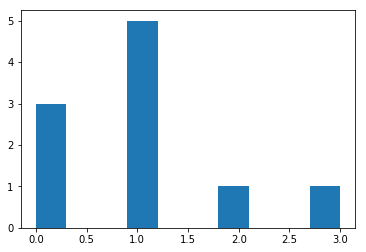

In [24]:
%matplotlib inline

class MoneyAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1
        
    def step(self):
        if self.wealth == 0:
            return
        other_agent = self.random.choice(self.model.schedule.agents)
        other_agent.wealth += 1
        self.wealth -= 1
        
class MoneyModel(Model):
    def __init__(self, N):
        self.num_agents = N
        self.schedule = RandomActivation(self)
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            
    def step(self):
        self.schedule.step()
            
mod = MoneyModel(10)
for i in range(1):
    mod.step()
    
agent_wealth = [a.wealth for a in mod.schedule.agents]
plt.hist(agent_wealth)
plt.show()

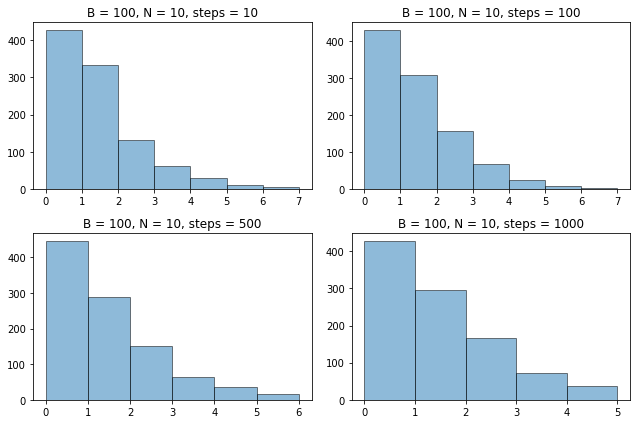

In [3]:
def simulate(B,N,steps):

    all_wealth = np.empty((B, N))

    for b in range(B):
        model = MoneyModel(N)
        for i in range(steps):
            model.step()

        all_wealth[b,:] = [a.wealth for a in model.schedule.agents]
        
    return all_wealth

fig, axes = plt.subplots(2,2,figsize=(9,6))
axes = axes.flatten()

for ax, (B,N,steps) in zip(axes, [[100, 10, 10], [100, 10, 100], [100, 10, 500], [100, 10, 1000]]):
    all_wealth = simulate(B,N,steps)
    all_wealth = all_wealth.flatten()
    
    ax.hist(all_wealth, edgecolor='k', alpha=0.5, bins=list(range(int(max(all_wealth)+1))))
    ax.set_title(f'B = {B}, N = {N}, steps = {steps}')

plt.tight_layout()
plt.show()

# Adding space

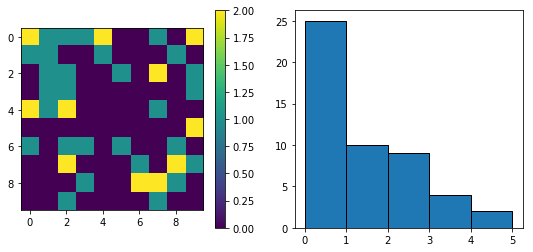

In [4]:
from mesa.space import MultiGrid

class MoneyAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1
        
    def move(self):
        possible_steps = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)
        
    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates)>1:
            other = self.random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1
        
    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()

class MoneyModel(Model):
    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = MultiGrid(width=width, height=height, torus=True)
        self.schedule = RandomActivation(self)
        
        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x,y))
            
    def step(self):
        self.schedule.step()
        

model = MoneyModel(N=50,width=10,height=10)
for i in range(20):
    model.step()
    
agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
    
wealths = [a.wealth for a in model.schedule.agents]
    
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(9,4))
    
pic = ax1.imshow(agent_counts, interpolation='nearest')
plt.colorbar(pic, ax=ax1)
ax2.hist(wealths, bins=list(range(int(max(all_wealth)+1))), edgecolor='k')

plt.show()

# Collecting data

In [5]:
from mesa.datacollection import DataCollector

def compute_gini(model):
    agent_wealths = [a.wealth for a in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum( xi * (N-i) for i,xi in enumerate(x) ) / (N*sum(x))
    return (1 + (1/N) - 2*B)

class MoneyModel(Model):
    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = MultiGrid(width=width, height=height, torus=True)
        self.schedule = RandomActivation(self)
        
        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x,y))
            
        self.datacollector = DataCollector(model_reporters={'Gini': compute_gini},
                                          agent_reporters={'Wealth':'wealth'})
            
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
        
model = MoneyModel(N=50, width=10, height=10)
for i in range(100):
    model.step()

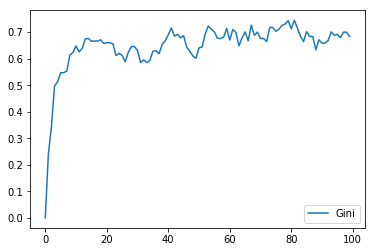

In [6]:
gini_df = model.datacollector.get_model_vars_dataframe()
plt.plot(gini_df.Gini)
plt.legend(loc=4)
plt.show()

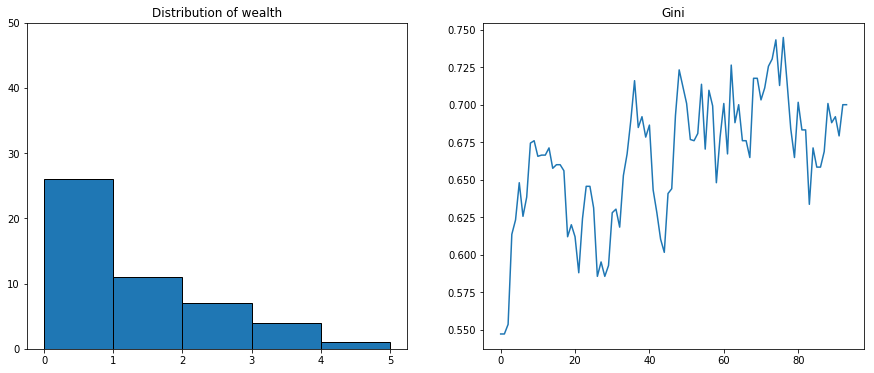

In [25]:
%matplotlib qt
import time

df = model.datacollector.get_agent_vars_dataframe()
df.tail(5)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,6))
for i in range(5,100):
    ax1.clear()
    ax1.hist(df.loc[i].values, bins = range(int(max(all_wealth)+1)), edgecolor='k')
    ax1.set_ylim((0,50))
    ax1.set_title('Distribution of wealth')
    
    ax2.clear()
    ax2.plot(gini_df.Gini.values[5:i])
    ax2.set_title('Gini')
    
    plt.pause(0.2)
    
plt.show()

# Batch run

In [8]:
from mesa.batchrunner import BatchRunner

class MoneyModel(Model):
    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = MultiGrid(width=width, height=height, torus=True)
        self.schedule = RandomActivation(self)
        self.running = True
        
        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x,y))
            
        self.datacollector = DataCollector(model_reporters={'Gini': compute_gini},
                                          agent_reporters={'Wealth':'wealth'})
            
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [12]:
fixed_params = {'width':10, 'height':10}
variable_params = {'N':range(10,100,10)}

batch_run = BatchRunner(model_cls=MoneyModel,
                       variable_parameters=variable_params,
                       fixed_parameters=fixed_params,
                       iterations=5,
                       max_steps=100,
                       model_reporters={'Gini':compute_gini})

batch_run.run_all()

45it [00:04,  5.94it/s]


In [13]:
run_df = batch_run.get_model_vars_dataframe()
run_df.head()

,N,Run,Gini,width,height
0,10,0,0.48,10,10
1,10,1,0.58,10,10
2,10,2,0.70,10,10
3,10,3,0.58,10,10
4,10,4,0.58,10,10


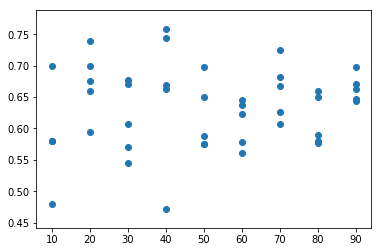

In [14]:
%matplotlib inline
plt.scatter(run_df.N, run_df.Gini)
plt.show()

In [ ]:
help(BatchRunner)